# Directional Coupler

In [1]:
# Import all the necessary packages
import gplugins.modes as gmode
import numpy as np
import matplotlib.pyplot as plt
import meep as mp
import gdsfactory as gf
import gplugins.gmeep as gm

Using MPI version 4.1, 1 processes
2025-10-02 00:21:52.537 | INFO     | gplugins.gmeep:<module>:39 - Meep '1.31.0' installed at ['/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/meep']


## Visualzing supermodes

Using gdsfactory and gplugins we can visualize the supermodes and effective index of even and odd modes

Refractive index of even mode: 2.412356873283017
Refractive index of odd mode: 2.3769074396552754


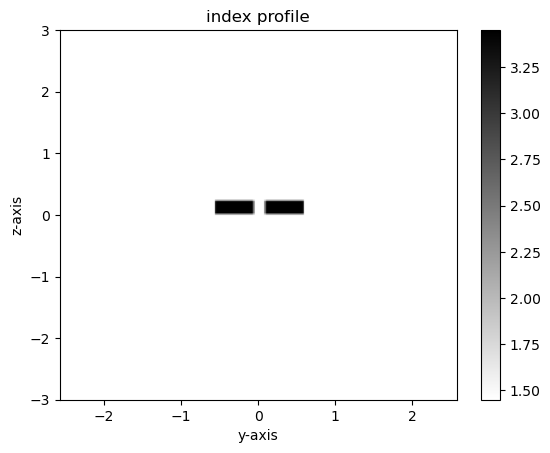

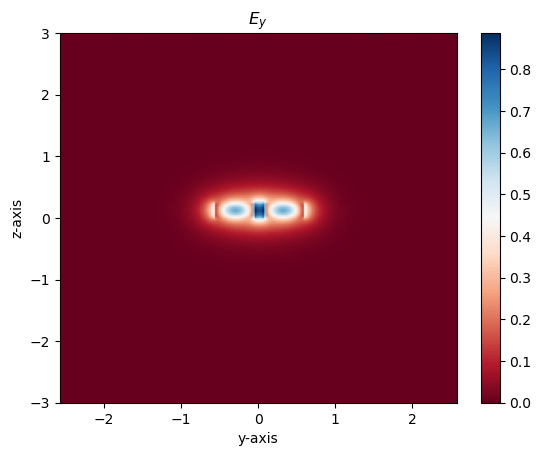

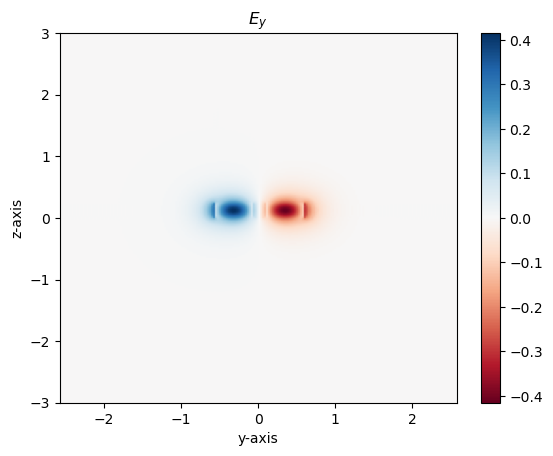

In [2]:
modes = gmode.find_modes_coupler(
    core_widths=(0.5, 0.5),
    gaps=(0.15,),  # CHANGE GAP VALUE
    core_material=3.45,
    clad_material=1.45,
    core_thickness=0.22,
    resolution=40,
    sz=6,
    nmodes=2,
)

m1 = modes[1]  # even mode
m2 = modes[2]  # odd mode

# Look to see how big of a difference there is between the two refractive indices
print("Refractive index of even mode:", m1.neff)
print("Refractive index of odd mode:", m2.neff)

# Plot the dielectric, shows index of refraction values in sidebar
m1.plot_eps()

# Plot the Electric field intensity of the modes
m1.plot_ey()
m2.plot_ey()

## Coupling length vs gap between the waveguides 

Using gdsfactory helper function 'find_coupling_vs_gap'

In [26]:
import meep as mp

coupling_gap = gmode.find_coupling_vs_gap(
    gap1=0.1,
    gap2=0.15,
    steps=11,
    nmodes=1,
    wavelength=1.55,
    parity=mp.EVEN_Y,
    core_widths=(0.5, 0.5),
    core_material=3.45,
    clad_material=1.45,
    core_thickness=0.22,
    resolution=40,
    sz=6,
)
coupling_gap

  0%|          | 0/11 [00:00<?, ?it/s]

,gap,ne,no,lc,dn
0,0.100,2.428738,2.371472,13.533461,0.057265
1,0.105,2.426836,2.371885,14.103476,0.054951
2,0.110,2.425519,2.372191,14.532637,0.053328
3,0.115,2.423959,2.372615,15.094336,0.051344
4,0.120,2.423082,2.373316,15.572816,0.049766
5,0.125,2.420206,2.373469,16.582260,0.046737
6,0.130,2.417458,2.373492,17.627312,0.043966
7,0.135,2.415176,2.373758,18.711407,0.041419
8,0.140,2.413491,2.374407,19.828922,0.039084
9,0.145,2.412899,2.375705,20.836274,0.037195


## Coupling power ratio vs length of the waveguide

$\kappa^2 = sin^2(C.L)$ cross coupling ratio

$t^2 = cos^2(C.L)$ through coupling ratio

$C = \frac{\pi\Delta n}{\lambda}$ Coupling coefficient

$c_{length} = \frac{\lambda}{2*\Delta n}$ Cross-over length

gap = 150 nm, n1 = 2.412, n2=2.377

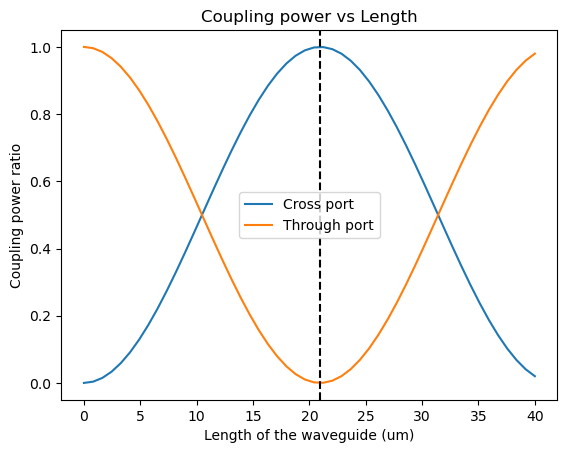

In [6]:
gap = 0.150  # in um
n1 = 2.412
n2 = 2.375
dn = 2.412 - 2.375
L = np.linspace(0, 40, 50)
C = np.pi * dn / 1.55  # coupling coeff
k_cross = (np.sin(C * L)) ** 2
t_through = (np.cos(C * L)) ** 2
C_len = 1.55 / (2 * dn)
plt.figure()
plt.plot(L, k_cross, label="Cross port")
plt.plot(L, t_through, label="Through port")
plt.axvline(C_len, color="black", linestyle="--")
plt.xlabel("Length of the waveguide (um)")
plt.ylabel("Coupling power ratio")
plt.title("Coupling power vs Length")
plt.legend()
plt.show()

# Meep simulation of coupler

No bend simualtion - two straight waveguide seperated by gap=0.15 um, Length=22 um

FloatProgress(value=0.0, description='0% done ', max=400.0)

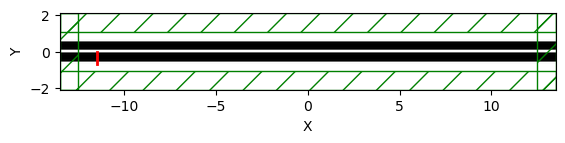

In [8]:
import meep as mp
from PIL import Image
import glob
import os

# Define materials
Si = mp.Medium(index=3.45)
SiO2 = mp.Medium(index=1.45)

# Define wavelength in um
wvl = 1.55

# # Define cell and geometric parameters
resolution = 20
wg_width = 0.5
dpml = 1
pad = 0.5

## CHANGE GAP DISTANCE ##
gap = 0.15
## CHANGE WAVEGUIDE LENGTH ##
Lx = 25

Sx = dpml + Lx + dpml
Sy = dpml + pad + wg_width + gap + wg_width + pad + dpml
wg_center_y = gap / 2 + wg_width / 2

# Add PML (perfectly matched layers)
pml = [mp.PML(dpml)]

# Create 2 infinitely long parallel waveguides
geometry = [
    mp.Block(size=mp.Vector3(Sx, Sy, 0), center=mp.Vector3(), material=SiO2),
    mp.Block(
        size=mp.Vector3(Sx, wg_width, 0),
        center=mp.Vector3(0, wg_center_y, 0),
        material=Si,
    ),
    mp.Block(
        size=mp.Vector3(Sx, wg_width, 0),
        center=mp.Vector3(0, -wg_center_y, 0),
        material=Si,
    ),
]

# Put a pulse Eigenmode source at beginning of one waveguide
fcen = 1 / wvl
width = 0.1
fwidth = width * fcen
src = mp.GaussianSource(frequency=fcen, fwidth=fwidth)
source = [
    mp.EigenModeSource(
        src=src,
        eig_band=1,
        eig_kpoint=(1, 0, 0),
        size=mp.Vector3(0, gap + wg_width),
        center=mp.Vector3(-Sx / 2 + dpml + 1, -wg_center_y),
    )
]

# Simulation object
sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy),
    boundary_layers=pml,
    geometry=geometry,
    sources=source,
    default_material=SiO2,
    resolution=resolution,
)

# Show simulation set-up
sim.plot2D()

sim.reset_meep()
# Capture electric field intensity over time and output into a gif
sim.run(
    mp.at_beginning(mp.output_epsilon),
    mp.to_appended("ez_100_DC", mp.at_every(2, mp.output_efield_z)),
    until=400,
)

# Since HDf5 was installed locally we need this. For sudo install these steps are not needed
os.environ["PATH"] = os.path.expanduser("~") + "/local/bin:" + os.environ["PATH"]
conda_prefix = os.environ["CONDA_PREFIX"]
os.environ["LD_LIBRARY_PATH"] = (
    conda_prefix + "/lib:" + os.environ.get("LD_LIBRARY_PATH", "")
)
os.system(
    "h5topng -t 0:99 -R -Zc $HOME/local/share/h5utils/colormaps/RdBu -A eps-000000.00.h5 -a $HOME/local/share/h5utils/colormaps/gray ez_100_DC.h5"
)

# Create a gif from the pngs
frames = []
imgs = glob.glob("ez_100_DC.t*")
imgs.sort()
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

# Save into a GIF file that loops forever
frames[0].save(
    "ez_100_DC.gif", format="GIF", append_images=frames[1:], save_all=True, loop=0
)

# Clean up workspace by deleting all generated images
for i in imgs:
    os.remove(i)
for f in glob.glob("*.h5"):
    os.remove(f)

![SegmentLocal](ez_DC_meep.gif "segment")

# Coupler with bends - S-Parameter
1. Use write_sparameters_meep from gdsfactory plugins gmeep to get the sparameter of 100% coupler

2. Use get_geomentry from gdsfacotory to calcaulate S paramters and steady state fields. 

3. Get Field animations

### Couplers from gdsfactory component

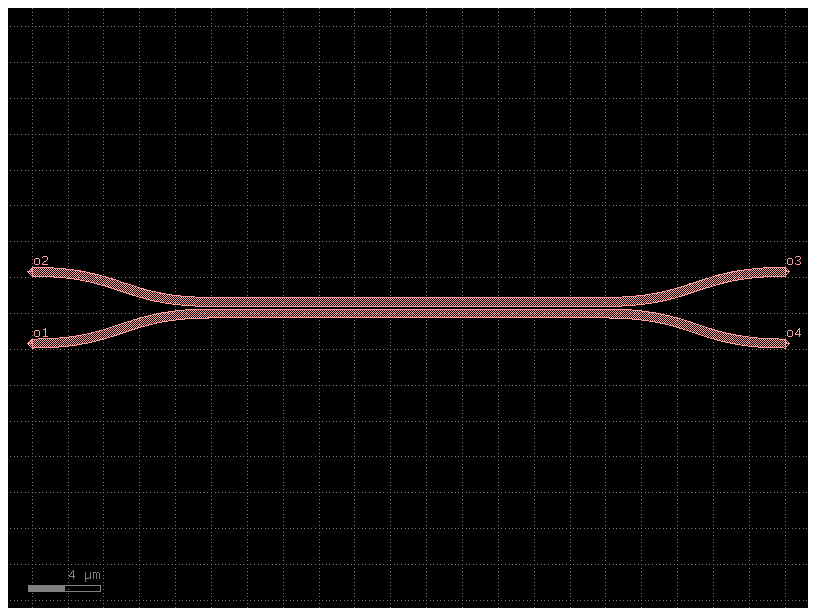

In [2]:
import gdsfactory as gf

gf.clear_cache()
dir_coupler_100 = gf.Component("100% coupler")

gap = 0.15
length_100 = 22


dir_100_ref = dir_coupler_100.add_ref(gf.components.coupler(gap=gap, length=length_100))
dir_coupler_100.add_ports(dir_100_ref.ports)


dir_coupler_100.draw_ports()
dir_coupler_100.plot()

Effective index calcaution for 2.5D simulations (Not accurate like 3D simualtion but close enough and way faster)

In [4]:
import gplugins

core_material = gplugins.get_effective_indices(
    core_material=3.45,
    clad_materialding=1.44,
    nsubstrate=1.44,
    thickness=0.22,
    wavelength=1.55,
    polarization="te",
)[0]

core_material

2.8217018611269684

## Using write_sparameters_meep function

/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/meep/visualization.py:966: UserWarning: plot_eps_flag is deprecated. Use show_epsilon instead.
  warnings.warn("plot_eps_flag is deprecated. Use show_epsilon instead.")
/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/meep/__init__.py:4446: ComplexWarning: Casting complex values to real discards the imaginary part
  return _meep._get_epsilon_grid(gobj_list, mlist, _default_material, _ensure_periodicity, gv, cell_size, cell_center, nx, xtics, ny, ytics, nz, ztics, grid_vals, frequency)


  0%|          | 0/4 [00:00<?, ?it/s]

/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/meep/__init__.py:4440: ComplexWarning: Casting complex values to real discards the imaginary part
  return _meep.create_structure(cell_size, dft_data_list_, pml_1d_vols_, pml_2d_vols_, pml_3d_vols_, absorber_vols_, gv, br, sym, num_chunks, Courant, use_anisotropic_averaging, tol, maxeval, gobj_list, center, _ensure_periodicity, _default_material, alist, extra_materials, split_chunks_evenly, set_materials, existing_s, output_chunk_costs, my_bp)
/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/meep/__init__.py:4443: ComplexWarning: Casting complex values to real discards the imaginary part
  return _meep._set_materials(s, cell_size, gv, use_anisotropic_averaging, tol, maxeval, gobj_list, center, _ensure_periodicity, _default_material, alist, extra_materials, split_chunks_evenly, set_materials, existing_geps, output_chunk_costs, my_bp)


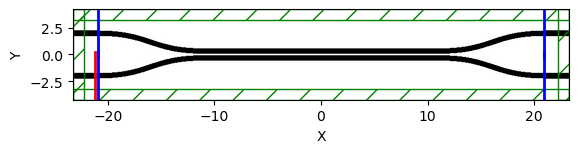

In [8]:
import meep as mp
import matplotlib.pyplot as plt
import gplugins.gmeep as gm

mp.verbosity(0)

# Define materials
Si = mp.Medium(index=3.45)
SiO2 = mp.Medium(index=1.45)

resolution = 20
dpml = 1
pad = 1

sx = dpml + -(dir_coupler_100.ports["o1"].x) + (dir_coupler_100.ports["o4"].x) + dpml
sy = (
    dpml
    + pad
    + -(dir_coupler_100.ports["o1"].y)
    + (dir_coupler_100.ports["o4"].y)
    + pad
    + dpml
)

port_symmetries_crossing = {
    "o1@0,o1@0": ["o2@0,o2@0", "o3@0,o3@0", "o4@0,o4@0"],
    "o2@0,o1@0": ["o1@0,o2@0", "o3@0,o4@0", "o4@0,o3@0"],
    "o3@0,o1@0": ["o1@0,o3@0", "o2@0,o4@0", "o4@0,o2@0"],
    "o4@0,o1@0": ["o1@0,o4@0", "o2@0,o3@0", "o3@0,o2@0"],
}
# plotting the meep geomentry
gm.write_sparameters_meep(
    dir_coupler_100,
    xmargin_left=1,
    xmargin_right=1,
    ymargin_top=1,
    ymargin_bot=1,
    resolution=resolution,
    wavelength_start=1.54,
    wavelength_stop=1.56,
    wavelength_points=100,
    tpml=dpml,
    port_source_offset=0.2,
    port_monitor_offset=-0.1,
    port_symmetries=port_symmetries_crossing,
    distance_source_to_monitors=0.3,
    material_name_to_meep=dict(si=3.45),
    run=False,
)

# Running the simulations
sp = gm.write_sparameters_meep(
    dir_coupler_100,
    xmargin_left=1,
    xmargin_right=1,
    ymargin_top=1,
    ymargin_bot=1,
    wavelength_start=1.54,
    wavelength_stop=1.56,
    wavelength_points=100,
    resolution=resolution,
    tpml=dpml,
    port_source_offset=0.2,
    port_monitor_offset=-0.1,
    distance_source_to_monitors=0.3,
    port_symmetries=port_symmetries_crossing,
    material_name_to_meep=dict(si=3.45),
    run=True,
)

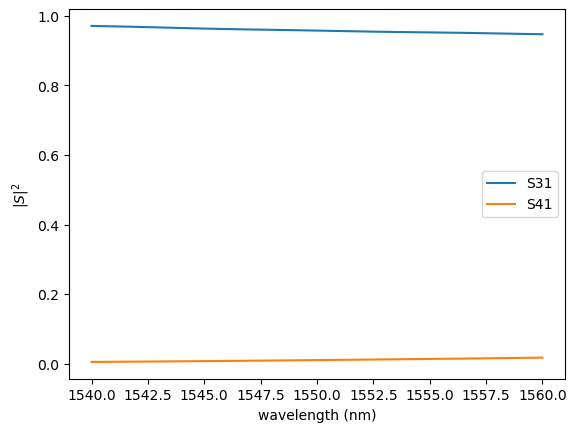

In [10]:
gm.plot.plot_sparameters(
    sp,
    keys=(
        "o3@0,o1@0",
        "o4@0,o1@0",
    ),
    logscale=False,
)

## Using meep 2D simualtion vary length 

calculating the s_parameter and the steady state fields for varying length

Length = [10, 15, 22, 30, 40], gap = 0.15

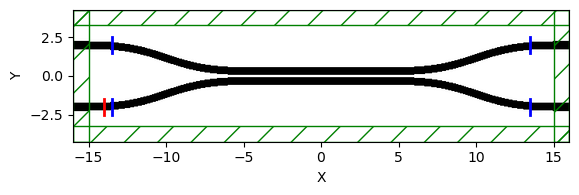

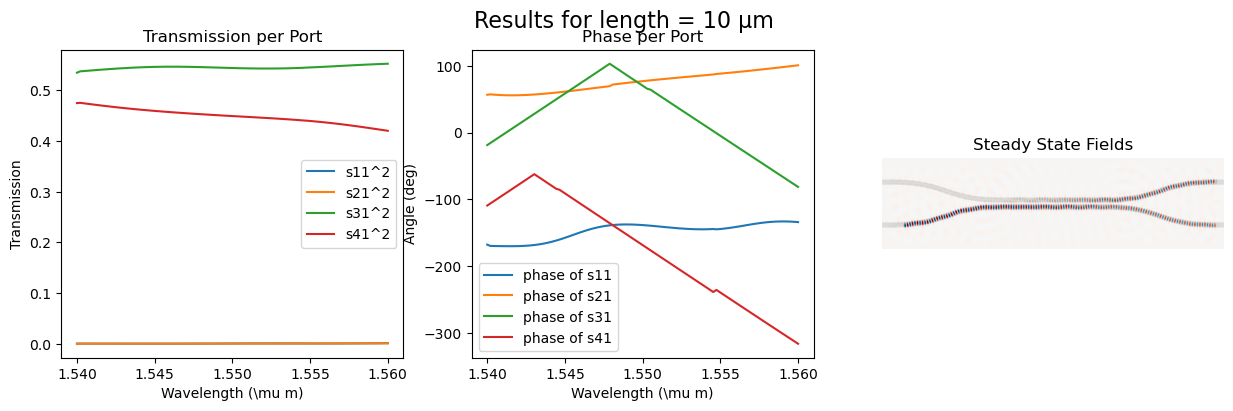

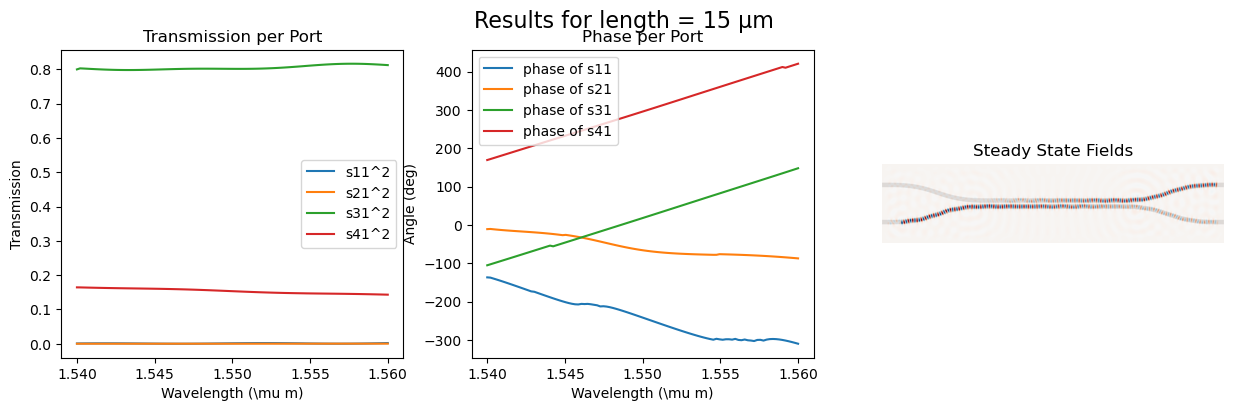

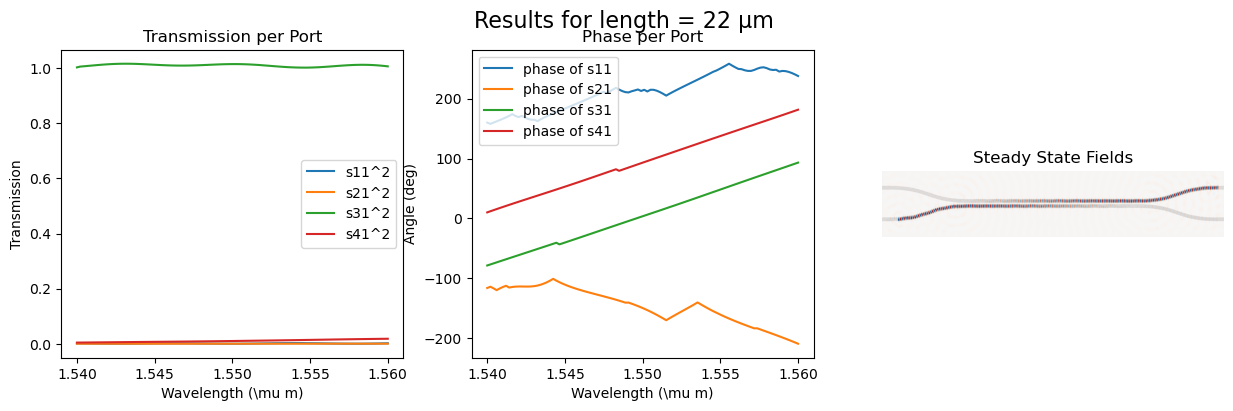

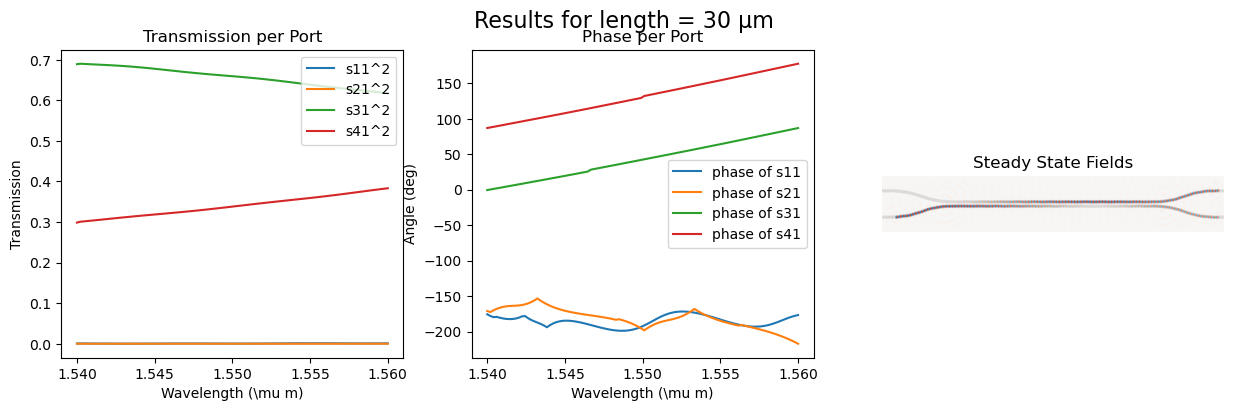

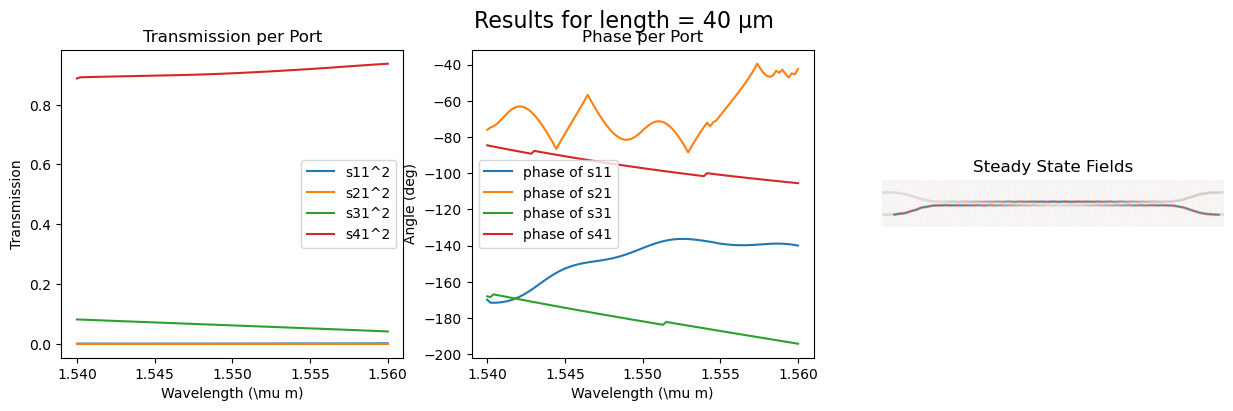

In [22]:
from gdsfactory.technology import LayerLevel, LayerStack

mp.verbosity(0)

# Set up frequency points for simulation
npoints = 100
lcen = 1.55
dlam = 0.02
wl = np.linspace(lcen - dlam / 2, lcen + dlam / 2, npoints)
fcen = 1 / lcen
fwidth = 3 * dlam / lcen**2
fpoints = 1 / wl  # Center frequency
mode_parity = mp.EVEN_Y + mp.ODD_Z

# Define simulation parameters
gap = 0.15  # Choosen a small value to reduce the coupling length for faster simualtion
lengths = [10, 15, 22, 30, 40]
t_Si = 0.220
resolution = 20  # resoultion (using low value for faster simualtion)
dpml = 1
dpad = 1

# Define materials
Si = mp.Medium(index=3.45)
SiO2 = mp.Medium(index=1.45)

s_cross = []  # to save the S parameter for the cross port
s_through = []  # to save the S parameter for the through port
for length in lengths:
    dir_coupler = gf.components.coupler(gap=gap, length=length)

    cell_size = mp.Vector3(
        dir_coupler.xsize + 2 * dpml, dir_coupler.ysize + 2 * dpml + 2 * dpad, 0
    )

    layers = dict(
        core=LayerLevel(
            layer=(1, 0),
            thickness=t_Si,
            zmin=-t_Si / 2,
            material="si",
            mesh_order=2,
            sidewall_angle=0,
            width_to_z=0.5,
            orientation="100",
        )
    )
    layer_stack = LayerStack(layers=layers)

    dir_coupler = gf.components.extend_ports(
        dir_coupler, port_names=["o1", "o2", "o3", "o4"], length=1
    )
    dir_coupler = dir_coupler.copy()
    dir_coupler.flatten()
    dir_coupler.center = (0, 0)  # unsure why centering is needed

    geometry = gm.get_meep_geometry.get_meep_geometry_from_component(
        dir_coupler, layer_stack=layer_stack
    )

    geometry = [
        mp.Prism(geom.vertices, geom.height, geom.axis, geom.center, material=Si)
        for geom in geometry
    ]

    src = mp.GaussianSource(frequency=fcen, fwidth=fwidth)
    source = [
        mp.EigenModeSource(
            src=src,
            eig_band=1,
            eig_parity=mode_parity,
            size=mp.Vector3(0, 1),
            center=mp.Vector3(
                dir_coupler.ports["o1"].x + dpml + 1, dir_coupler["o1"].y
            ),
        )
    ]
    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=[
            mp.PML(dpml)
        ],  # the boundary layers to absorb fields that leave the simulation
        sources=source,  # The sources
        geometry=geometry,  # The geometry
        default_material=SiO2,
    )
    m1 = mp.Volume(
        center=mp.Vector3(
            dir_coupler.ports["o1"].x + dpml + 1 + 0.5, dir_coupler["o1"].y
        ),
        size=mp.Vector3(0, 1),
    )
    m2 = mp.Volume(
        center=mp.Vector3(
            dir_coupler.ports["o2"].x + dpml + 1 + 0.5, dir_coupler["o2"].y
        ),
        size=mp.Vector3(0, 1),
    )
    m3 = mp.Volume(
        center=mp.Vector3(
            dir_coupler.ports["o3"].x - dpml - 1 - 0.5, dir_coupler["o3"].y
        ),
        size=mp.Vector3(0, 1),
    )
    m4 = mp.Volume(
        center=mp.Vector3(
            dir_coupler.ports["o4"].x - dpml - 1 - 0.5, dir_coupler["o4"].y
        ),
        size=mp.Vector3(0, 1),
    )

    mode_monitor_1 = sim.add_mode_monitor(fpoints, mp.ModeRegion(volume=m1))
    mode_monitor_2 = sim.add_mode_monitor(fpoints, mp.ModeRegion(volume=m2))
    mode_monitor_3 = sim.add_mode_monitor(fpoints, mp.ModeRegion(volume=m3))
    mode_monitor_4 = sim.add_mode_monitor(fpoints, mp.ModeRegion(volume=m4))
    whole_dft = sim.add_dft_fields(
        [mp.Ez], fcen, 0, 1, center=mp.Vector3(), size=cell_size
    )
    if length == 10:
        sim.plot2D(labels=False)

    # Runs the simulation
    sim.run(until_after_sources=mp.stop_when_dft_decayed(tol=1e-4))

    # Finds the S parameters
    norm_mode_coeff = sim.get_eigenmode_coefficients(
        mode_monitor_1, [1], eig_parity=mode_parity
    ).alpha[0, :, 0]
    port1_coeff = (
        sim.get_eigenmode_coefficients(
            mode_monitor_1, [1], eig_parity=mode_parity
        ).alpha[0, :, 1]
        / norm_mode_coeff
    )
    port2_coeff = (
        sim.get_eigenmode_coefficients(
            mode_monitor_2, [1], eig_parity=mode_parity
        ).alpha[0, :, 1]
        / norm_mode_coeff
    )
    port3_coeff = (
        sim.get_eigenmode_coefficients(
            mode_monitor_3, [1], eig_parity=mode_parity
        ).alpha[0, :, 0]
        / norm_mode_coeff
    )
    port4_coeff = (
        sim.get_eigenmode_coefficients(
            mode_monitor_4, [1], eig_parity=mode_parity
        ).alpha[0, :, 0]
        / norm_mode_coeff
    )

    # Calculates the transmittance based off of the S parameters
    port1_trans = abs(port1_coeff) ** 2
    port2_trans = abs(port2_coeff) ** 2
    port3_trans = abs(port3_coeff) ** 2
    port4_trans = abs(port4_coeff) ** 2

    val = 1.55
    idx = (np.abs(wl - val)).argmin()

    s_cross.append(port3_trans[idx])
    s_through.append(port4_trans[idx])

    fig = plt.figure(figsize=(15, 4))
    fig.suptitle(f"Results for length = {length} µm", fontsize=16)

    ax_trans1 = fig.add_subplot(1, 3, 1)
    ax_trans1.set_title("Transmission per Port")
    ax_trans1.plot(wl, port1_trans, label=r"s11^2")
    ax_trans1.plot(wl, port2_trans, label=r"s21^2")
    ax_trans1.plot(wl, port3_trans, label=r"s31^2")
    ax_trans1.plot(wl, port4_trans, label=r"s41^2")
    ax_trans1.set_xlabel(r"Wavelength (\mu m)")
    ax_trans1.set_ylabel(r"Transmission")
    ax_trans1.legend()

    ax_phase1 = fig.add_subplot(1, 3, 2)
    ax_phase1.set_title("Phase per Port")
    ax_phase1.plot(
        wl, np.unwrap(np.angle(port1_coeff) * 180 / np.pi), label=r"phase of s11"
    )
    ax_phase1.plot(
        wl, np.unwrap(np.angle(port2_coeff) * 180 / np.pi), label=r"phase of s21"
    )
    ax_phase1.plot(
        wl, np.unwrap(np.angle(port3_coeff) * 180 / np.pi), label=r"phase of s31"
    )
    ax_phase1.plot(
        wl, np.unwrap(np.angle(port4_coeff) * 180 / np.pi), label=r"phase of s41"
    )
    ax_phase1.set_xlabel(r"Wavelength (\mu m)")
    ax_phase1.set_ylabel("Angle (deg)")
    ax_phase1.legend()

    # sim.reset_meep()

    # sim.run(until_after_sources=mp.stop_when_dft_decayed(tol=1e-4))

    eps_data = (
        sim.get_epsilon()
    )  # Epsilon Data / The Geometry / An array that holds what materials are where
    ez_data = sim.get_dft_array(
        whole_dft, mp.Ez, 0
    )  # Values for the component of the E-field in the z direction (in/out of screen)

    # Creates the plot
    ax_field = fig.add_subplot(1, 3, 3)
    ax_field.set_title("Steady State Fields")
    ax_field.imshow(np.transpose(eps_data), interpolation="spline36", cmap="binary")
    ax_field.imshow(
        np.flipud(np.transpose(np.real(ez_data))),
        interpolation="spline36",
        cmap="RdBu",
        alpha=0.9,
    )
    ax_field.axis("off")

plt.show()

## Power Coupling Comparsion between the FDTD and mode solver approach

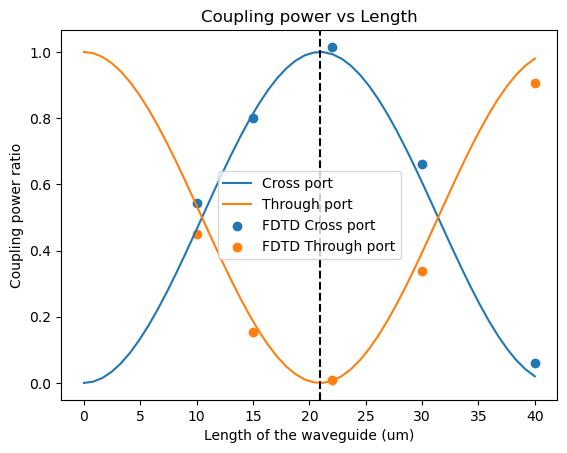

In [24]:
plt.figure()
plt.plot(L, k_cross, label="Cross port")
plt.plot(L, t_through, label="Through port")

plt.scatter(lengths, s_cross, label="FDTD Cross port")
plt.scatter(lengths, s_through, label="FDTD Through port")

plt.axvline(C_len, color="black", linestyle="--")
plt.xlabel("Length of the waveguide (um)")
plt.ylabel("Coupling power ratio")
plt.title("Coupling power vs Length")
plt.legend()
plt.show()

## Field animation 

Animating the fields for visualization. Using gmeep plugings in gdsfactory 

FloatProgress(value=0.0, description='0% done ', max=200.0)

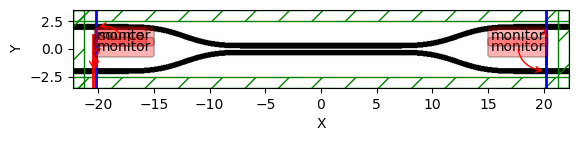

In [13]:
mp.verbosity(0)

wvl = 1.55
resolution = 20
dpml = 1
pad = 1

sx = dpml + -(dir_coupler_100.ports["o1"].x) + (dir_coupler_100.ports["o4"].x) + dpml
sy = (
    dpml
    + pad
    + -(dir_coupler_100.ports["o1"].y)
    + (dir_coupler_100.ports["o4"].y)
    + pad
    + dpml
)

cell_size = mp.Vector3(sx, sy)

dir_coupler_100 = gf.components.extend_ports(
    dir_coupler_100, port_names=["o1", "o2", "o3", "o4"], length=1
)

geometry_100 = gm.get_meep_geometry.get_meep_geometry_from_component(
    dir_coupler_100.copy()
)

fcen = 1 / wvl
width = 0.1
fwidth = width * fcen
src = mp.GaussianSource(frequency=fcen, fwidth=fwidth)
source = [
    mp.EigenModeSource(
        src=src,
        eig_band=1,
        eig_kpoint=(1, 0),
        size=mp.Vector3(0, 1),
        center=mp.Vector3(
            -dir_coupler_100.ports["o1"].x + dpml + 1, -dir_coupler_100["o1"].y / 2
        ),
    )
]

sim = gm.get_simulation(
    dir_coupler_100,
    resolution=resolution,
    tpml=1,
    port_source_offset=0.2,
    port_monitor_offset=-0.1,
    distance_source_to_monitors=0.3,
)
sim["sim"].sources = sim["sources"]
sim["sim"].cell_size.y = sy + 3
sim["sim"].cell_size.x = sx + 4

sim["sim"].plot2D(labels=True)

sim["sim"].reset_meep()
# Capture electric field intensity over time and output into a gif
sim["sim"].run(
    mp.at_beginning(mp.output_epsilon),
    mp.to_appended("ez", mp.at_every(2, mp.output_efield_z)),
    until=200,
)

os.environ["PATH"] = os.path.expanduser("~") + "/local/bin:" + os.environ["PATH"]
conda_prefix = os.environ["CONDA_PREFIX"]
os.environ["LD_LIBRARY_PATH"] = (
    conda_prefix + "/lib:" + os.environ.get("LD_LIBRARY_PATH", "")
)
os.system(
    "h5topng -t 0:99 -R -Zc $HOME/local/share/h5utils/colormaps/RdBu -A eps-000000.00.h5 -a $HOME/local/share/h5utils/colormaps/gray ez.h5"
)

# Create a gif from the pngs
frames = []
imgs = glob.glob("ez.t*")
imgs.sort()
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

# Save into a GIF file that loops forever
frames[0].save(
    "ez_100_DC.gif", format="GIF", append_images=frames[1:], save_all=True, loop=0
)

# Clean up workspace by deleting all generated images
for i in imgs:
    os.remove(i)

![SegmentLocal](ez_100_DC.gif "segment")